# Lab - Data Collection - Training
## E6692 Spring 2022

VERSION WITH SOLUTIONS

In part 1 of this lab we will be collecting and labeling data for a classification task with the Logitech webcam, training classification models, and performing live inference through the webcam with the trained models. We will define and train a custom CNN classification model that inherits from the PyTorch **nn.Module**, as well as fine tuning a pretrained ResNet model. 

To use the webcam in this lab you need to specify it when mounting the docker by adding the tag `--device /dev/video0`. Additionally, you should include a data volume for storing images. We recommended that you have a `data` folder in the root directory of your Jetson Nano, and subsequent lab folders within this data folder. For example, the data for this lab would be stored in `~/data/Lab-DataCollectionAndTraining`. Then you can include the external data directory when mounting the docker with `--volume ~/data/Lab-DataCollectionAndTraining:/docker/path/to/lab`.

## Part 1.1: Data Collection for Classification

In this part we collect and label image data for classification using the Jetson Nano webcam.

In [1]:
# import modules
import os
import torch
import torchvision
import torchvision.transforms as T

from utils.data_collection import collect_categorical_data, DATA_SHAPE
from utils.datasets import ClassificationDataset
from utils.models import CustomClassifier
from utils.training import train_classification, plot_loss_and_accuracy
from utils.live_inference import live_classification

# define paths
data_path = './data/classification'
if not os.path.exists(data_path):
    os.makedirs(data_path)

train_path = os.path.join(data_path, 'train')
if not os.path.exists(train_path):
    os.makedirs(train_path)

val_path = os.path.join(data_path, 'val')
if not os.path.exists(val_path):
    os.makedirs(val_path)
    
models_path = './models'
if not os.path.exists(models_path):
    os.makedirs(models_path)

device = torch.device('cuda')
print("GPU name: ", torch.cuda.get_device_name(0))

# reload modules every 2 seconds to see changes in notebook
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

GPU name:  NVIDIA Tegra X1


### Define A Classification Problem

Define the classification problem by enumerating the classes that we intend to predict. For example, image classification problems include the prediction of number of fingers in the frame, sign language characters, thumb up vs thumb down, hat on vs hat off, etc. Define your own classification problem, but keep in mind the limitations of collecting data through the webcam (relatively low resolution, confined to objects in the lab, time needed to label) and the capacity of models you are able to run on the Jetson Nano.

In [2]:
# TODO: define the names of classes that will be predicted and a name for the classification task. 
# Replace the following list elements with your classes

class_names = ['HaveMask', 'NoMask', 'NoPerson']
classification_task_name = 'MaskDetection'


### Collect, Preprocess, and Label Data

TODO: complete the methods of the class **ClassificationDataset** in **utils/datasets.py**. This class inherits from **torch.utils.data.Dataset** to give us compatibility between our custom classification dataset and **torch.utils.data.DataLoader** functionality. 

#### Data Augmentation

To make our custom dataset more robust, we will apply data augmentation transforms.

TODO: visit the documentation page for **[torchvision.transforms](https://pytorch.org/vision/main/auto_examples/plot_transforms.html)** to familiarize yourself with data augmentation transforms. Then use **torchvision.transforms.Compose()** to define a data augmentation pipeline.

NOTE: be careful not to augment your data in a way that would change it's label. For example, if your classification task is predicting thumb up vs thumb down, vertical flips of the image would be a poor choice of data augmentation!


In [3]:
# TODO: Use torchvision.transforms.Compose() to define a data augmentation pipeline

transforms = T.Compose([
    
    # insert data augmentations here
    
    T.Resize(DATA_SHAPE),
    T.ToTensor(), # don't modify Resize(), ToTensor() or Normalize().
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    T.ColorJitter(brightness=.5, hue=.3),
    T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    T.RandomRotation(degrees=(0, 30))
])


In [4]:
# TODO: define a training set and a validation set with the ClassificationDataset class.
path_train = 'data/classification/train'
path_val = 'data/classification/val'

train_set = ClassificationDataset(path_train, class_names, classification_task_name, transforms=None)

#### Should data augmentations be used on the validation set? Why or why not?

TODO: No. Because the data we get is not augmente, we are always blind to the testing data.

#### Collect and Label Data

Use the function **collect_categorical_data()** in **utils/data_collection.py** to collect categorical data for image classification. The base implementation of collect_categorical_data is sufficient for populating the training and validation classification datasets, but you are welcome to modify or improve it as you see fit.

In [5]:
# TODO: use collect_categorical_data() to collect training data

collect_categorical_data(class_names, train_set)


Data collection finished.


In [5]:
val_set = ClassificationDataset(path_val, class_names, classification_task_name, transforms=None)

In [14]:
# TODO: use collect_categorical_data() to collect validation data

collect_categorical_data(class_names, val_set)


Data collection finished.


#### Visualize Data

Complete the methods **get_random_image()** and **grid_visualization()** in **utils/datasets.ClassificationDataset**.

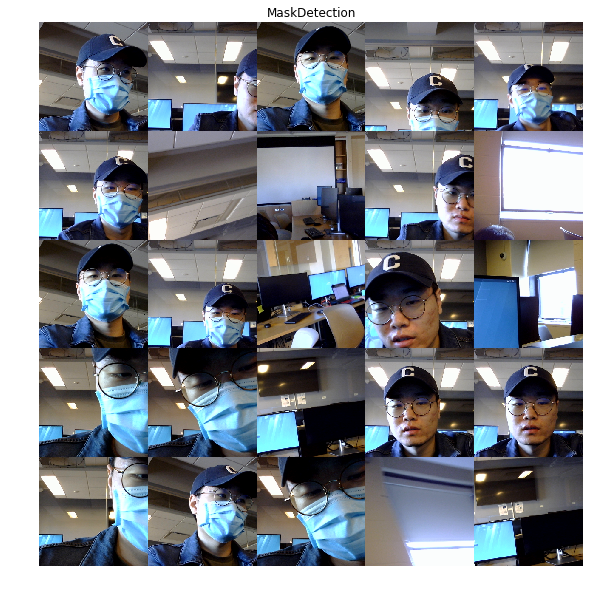

In [13]:
# TODO: use ClassificationDataset.grid_visualization() to view the training and validation sets.
train_set.grid_visualization()

#### Discuss the appearance of the train and validation sets. What characteristics are important to observe in a classification dataset before training?

TODO: Your answer here.

The training set and the validation set should be similar and needs to capture obvious features. Also there should not have too much unrelevant objects that may affect the performance.

## Part 1.2 Custom Classifier Model Definition

Now that we have a dataset, we will define a convolutional neural network classifier. We will use the [PyTorch functional API](https://pytorch.org/docs/stable/nn.functional.html) to construct a custom CNN classifier. Below is a diagram of what your basic model structure should look like. Note the convolutional layers for learning features and the fully connected layers for classification.

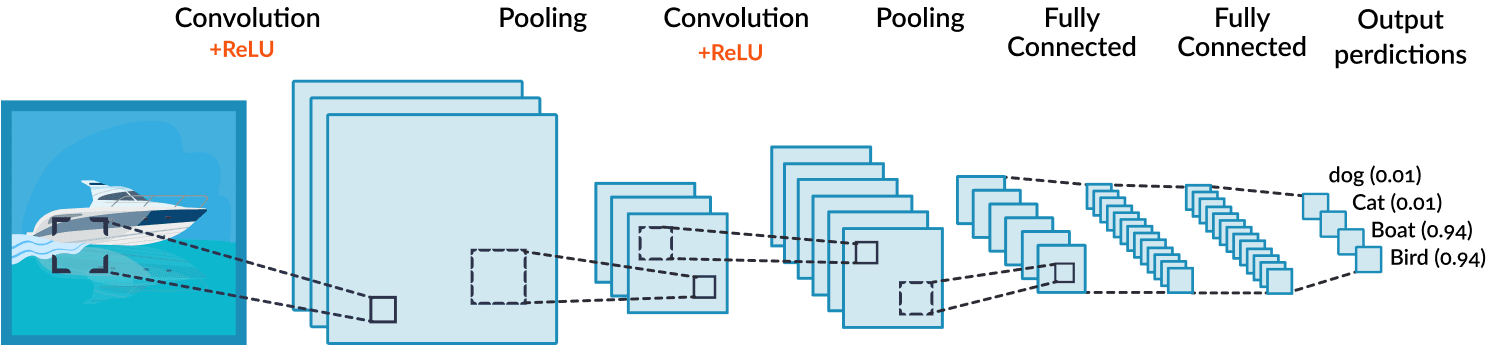

TODO: Complete the class **CustomClassifier** in **utils/models.py**. This class inherits from the [PyTorch nn.Module class](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), which gives it many functionalities including automatic handling of parameter transfer to the GPU. You must redefine the **CustomClassifier.forward()** method to define the forward pass of the model with your custom layers. 

NOTE: Keep in mind the limited memory resources of the Jetson Nano. You may experience issues (kernel dying, notebook freezing) if your model has too many parameters.

In [8]:
# Define instance of CustomClassifier

num_classes = len(class_names) # get the number of classes (output shape)
model = CustomClassifier(num_classes) # initialize model
model.to(device) # transfer model to GPU


CustomClassifier(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4608, out_features=32, bias=True)
    (17): ReLU()
    (18): Linear(in_features=32, out_features=3, bias=True)
    (19): ReLU()
  )
)

In [8]:
from torchvision import models
from torchsummary import summary

INPUT_SHAPE = (3,256,256)
summary(model.cuda(), (INPUT_SHAPE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 254, 254]             896
              ReLU-2         [-1, 32, 254, 254]               0
         AvgPool2d-3         [-1, 32, 127, 127]               0
            Conv2d-4         [-1, 32, 125, 125]           9,248
              ReLU-5         [-1, 32, 125, 125]               0
         AvgPool2d-6           [-1, 32, 62, 62]               0
            Conv2d-7           [-1, 64, 60, 60]          18,496
              ReLU-8           [-1, 64, 60, 60]               0
         AvgPool2d-9           [-1, 64, 30, 30]               0
           Conv2d-10           [-1, 64, 28, 28]          36,928
             ReLU-11           [-1, 64, 28, 28]               0
        AvgPool2d-12           [-1, 64, 14, 14]               0
           Conv2d-13          [-1, 128, 12, 12]          73,856
             ReLU-14          [-1, 128,

## Part 1.3 Custom Classifier Model Training

Now we need to train the model on our custom dataset. TODO: complete the function **train_classification()** in **utils/training.py**. Use the comments as a guide, and refer to the [PyTorch training loop documentation](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=def%20train_one_epoch(epoch_index%2C%20tb_writer)%3A). Your training loop should save the model with the highest validation accuracy score. 

NOTE: if you experience freezing or kernel dying, try reducing your batch size and defining a model with less parameters. 

In [9]:
# TODO: define model hyperparameters and use train_classification() to train 
#       your CNN classifier

batch_size = 8
epochs = 10
save_path = './models/classifier_2_e10_b8.pth'
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)


train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_classification(model, device, train_set, val_set, batch_size, optimizer, epochs, save_path)

Epoch: 1
sample:24, train_loss:0.1380, train_acc:0.0000
sample:56, train_loss:0.1387, train_acc:0.0000
sample:88, train_loss:0.1402, train_acc:0.0000
sample:120, train_loss:0.1380, train_acc:0.2667
Train Loss:0.1380, Acc:0.2667
Val Loss:0.1402, Acc:0.3162
Best model saved.


Epoch: 2
sample:24, train_loss:0.1377, train_acc:0.0000
sample:56, train_loss:0.1384, train_acc:0.0000
sample:88, train_loss:0.1400, train_acc:0.0000
sample:120, train_loss:0.1379, train_acc:0.2667
Train Loss:0.1379, Acc:0.2667
Val Loss:0.1402, Acc:0.3162


Epoch: 3
sample:24, train_loss:0.1374, train_acc:0.0000
sample:56, train_loss:0.1382, train_acc:0.0000
sample:88, train_loss:0.1399, train_acc:0.0000
sample:120, train_loss:0.1379, train_acc:0.2667
Train Loss:0.1379, Acc:0.2667
Val Loss:0.1402, Acc:0.3162


Epoch: 4
sample:24, train_loss:0.1372, train_acc:0.0000
sample:56, train_loss:0.1380, train_acc:0.0000
sample:88, train_loss:0.1398, train_acc:0.0000
sample:120, train_loss:0.1378, train_acc:0.2667
Train Loss

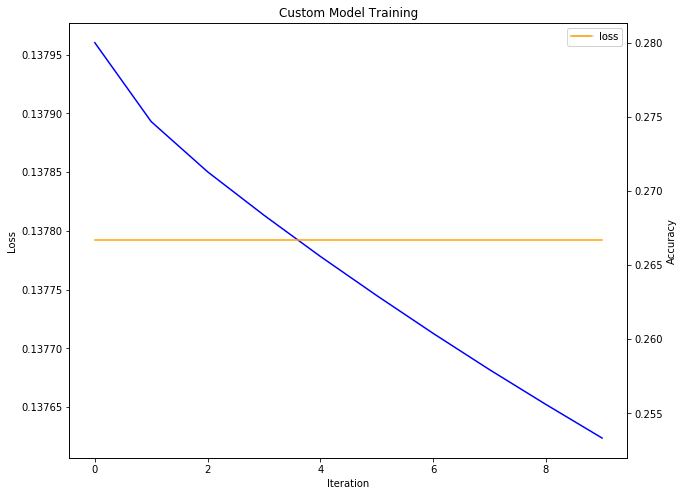

In [11]:
# TODO: plot training accuracy and loss with plot_loss_and_accuracy()

# plt.plot(train_acc_hist, label='train')
# plt.plot(val_acc_hist, label='val')
# plt.grid()
# plt.legend()
title = 'Custom Model Training'
labels = ['loss', 'acc']
plot_loss_and_accuracy(train_loss_hist, train_acc_hist, title, labels)

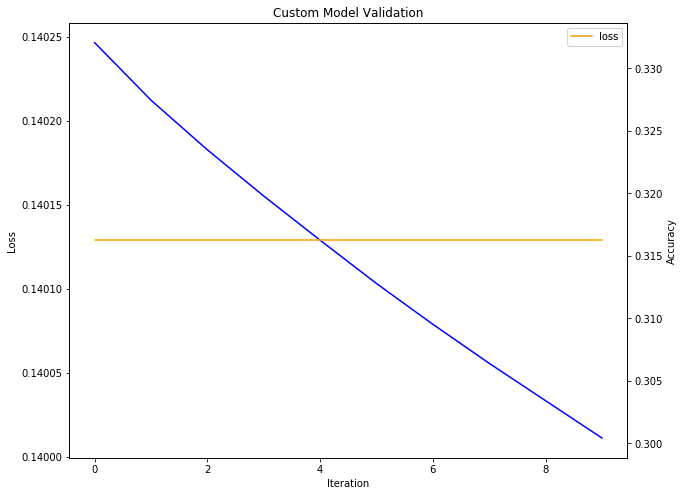

In [12]:
# TODO: plot validation accuracy and loss with plot_loss_and_accuracy()

title = 'Custom Model Validation'
labels = ['loss', 'acc']
plot_loss_and_accuracy(val_loss_hist, val_acc_hist, title, labels)

### Outline the results of your custom classifier training.

If you are not getting high validation accuracy you may need to collect more data, revise your model architecture, or adjust hyperparameters. Explain your process of improving the model's performance below.

TODO: Your answer here.

## Part 1.4 Custom Classifier Live Inference


We will now use the custom trained model to do live classification through the webcam. 

TODO: Complete the function **live_classification()** in **utils/live_inference.py**.

In [7]:
# TODO: execute live classification with the custom model using live_classification()

model_save_path = './models/classifier_resnet18_1_e5_b16.pth'
live_classification(model_save_path, model, device, class_names)


Video feed stopped.


### Discuss the performance of the live inference. Is the model able to do inference fast enough for the feed to be real time? Is the classification accurate?

TODO: Your answer here.

It can reach real time but not very fast. The accuracy is not really high, beacause of the lack of data.

### Insert a screenshot of your custom model classification live inference below.
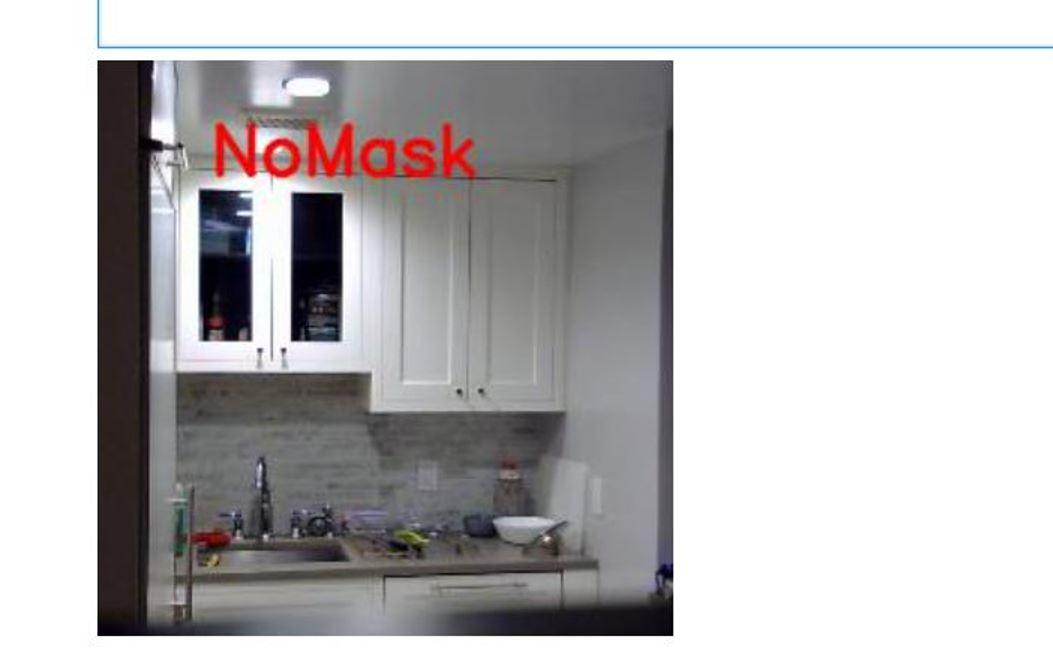

TODO: insert custom model classification screenshot here.

## Part 1.5 Pretrained Classifier

In this part we repeat parts 1.2 - 1.4 with a [pretrained ResNet18](https://pytorch.org/hub/pytorch_vision_resnet/). We have defined the pretrained PyTorch implementation below.


In [6]:
num_classes = len(class_names)
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(512, num_classes)
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
INPUT_SHAPE = (3,256,256)
summary(resnet18.cuda(), (INPUT_SHAPE))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /media/nvidia/NVME/pytorch/pytorch-v1.9.0/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [20]:
# TODO: use train_classification() to fine tune ResNet18 for your dataset

batch_size = 2
epochs = 20
save_path = './models/classifier_resnet18_1_e5_b16.pth'
optimizer = torch.optim.SGD(resnet18.parameters(), lr=1e-4, momentum=0.9)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_classification(resnet18, device, train_set, val_set, batch_size, optimizer, epochs, save_path)

Epoch: 1
sample:6, train_loss:1.3707, train_acc:0.0000
sample:14, train_loss:1.2100, train_acc:0.0000
sample:22, train_loss:1.0057, train_acc:0.0455
sample:30, train_loss:0.8176, train_acc:0.3000
sample:38, train_loss:0.6713, train_acc:0.4474
sample:46, train_loss:0.5635, train_acc:0.5435
sample:54, train_loss:0.6396, train_acc:0.5000
sample:62, train_loss:0.7308, train_acc:0.4355
sample:70, train_loss:0.7445, train_acc:0.3857
sample:78, train_loss:0.7028, train_acc:0.4103
sample:86, train_loss:0.6484, train_acc:0.4651
sample:94, train_loss:0.6941, train_acc:0.4468
sample:102, train_loss:0.7525, train_acc:0.4118
sample:110, train_loss:0.7666, train_acc:0.3818
sample:118, train_loss:0.7440, train_acc:0.3814
Train Loss:0.7352, Acc:0.3917
Val Loss:0.9918, Acc:0.3248
Best model saved.


Epoch: 2
sample:6, train_loss:1.2999, train_acc:0.0000
sample:14, train_loss:1.2472, train_acc:0.0000
sample:22, train_loss:1.1010, train_acc:0.0000
sample:30, train_loss:0.9209, train_acc:0.1000
sample:38,

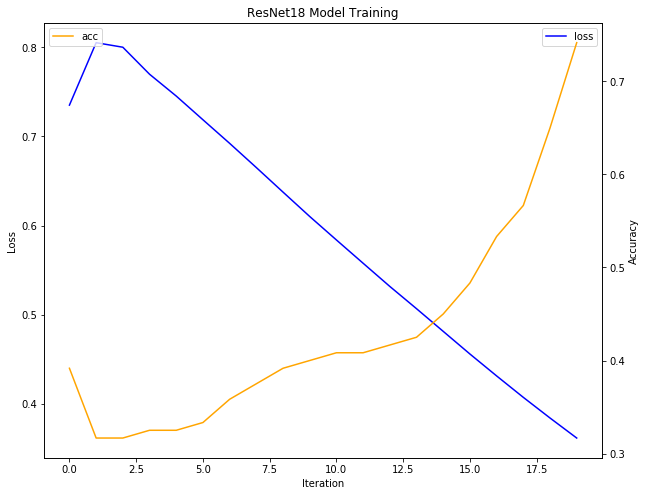

In [29]:
# TODO: plot training accuracy and loss of ResNet18 training with plot_loss_and_accuracy()
title = 'ResNet18 Model Training'
labels = ['loss', 'acc']
plot_loss_and_accuracy(train_loss_hist, train_acc_hist, title, labels)

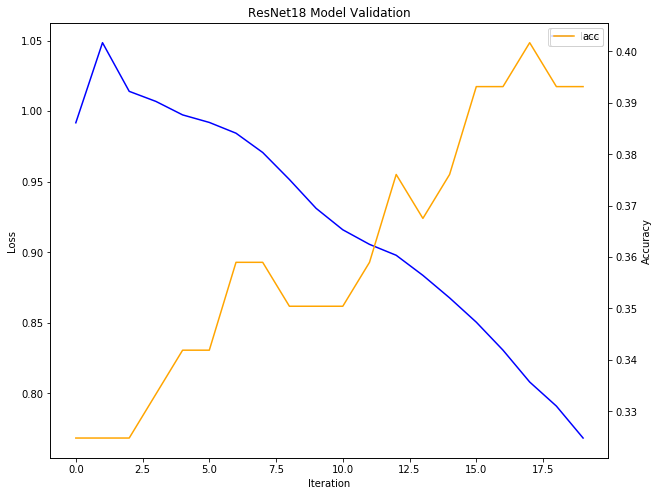

In [30]:
# TODO: plot validation accuracy and loss of ResNet18 training with plot_loss_and_accuracy()
title = 'ResNet18 Model Validation'
labels = ['loss', 'acc']
plot_loss_and_accuracy(val_loss_hist, val_acc_hist, title, labels)

In [8]:
# TODO: execute live classification with the ResNet18 using live_classification()
model_save_path = './models/classifier_resnet18_1_e5_b16.pth'
model = resnet18
live_classification(model_save_path, model, device, class_names)

Video feed stopped.


### Discuss the difference in performance between your custom model and the pretrained ResNet18. Were you able to fine tune the classification to your dataset? Which model's training and validation losses converged quicker? Why? Is there a considerable difference in inference speed between the two models?

TODO: Your answer here.

I'm able to fine tune the ResNet18 but it's bit of overfitting at the end. I think that's because of the size of my dataset is really not large enough. Also for my own model, it instantly converged and have almost no difference for the accuracy. I think it is also because of my dataset. 